# Análise Explorátoria de Dados

## Bibliotecas 

In [9]:
# Para tratamento dos dados
import pandas as pd
from pandasql import sqldf

# Para gráficos
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams # tamanho padrão

# para a análise de dados espaciais
import geopandas as gp

In [10]:
#values: xx-small, x-small, small, medium, large, x-large, xx-large, larger, or smaller

rcParams['figure.figsize'] = 10, 6 # Tamanho da Figura
rcParams['legend.fontsize'] = 'x-large' # Tamanho da Legenda
rcParams['legend.shadow'] = True # Sombra na Legenda
rcParams['legend.frameon'] = True # Desenha a Legenda em Uma Caixa Acima da Camada do Plot
rcParams['legend.framealpha'] = 0.8 # Nível de Transparência da Caixa da Legenda
rcParams['legend.edgecolor'] = 'black' # Cor da Borda da Caixa
rcParams['legend.fancybox'] = True # Caixa Arredondada ou Retangular
rcParams['legend.title_fontsize'] = 14 # Tamanho do Título da Legenda (Se None, então igual ao X e Y label)

## Carregando os Dados

In [11]:
df = pd.read_csv('dados/DadosReclameAqui.csv',delimiter=',')

In [29]:
df.shape

(2568, 11)

In [5]:
df.columns

Index(['row_hash', 'empresa', 'titulo', 'local', 'estado', 'data_abertura',
       'data_fechamento', 'dias_passados', 'status', 'vfn', 'nota'],
      dtype='object')

In [12]:
df = df.replace({'empresa':{'Allianz Seguros e SulAmérica Auto, Residencial e Condomínio.':'Allianz Seguros'}})

In [13]:
df.head()

,row_hash,empresa,titulo,local,estado,data_abertura,data_fechamento,dias_passados,status,vfn,nota
0,ZXS9oiFD6QQGH+/onOCrPw==,Bradesco Seguros,Dificuldade de solução,Viçosa - MG,MG,2022-04-18,2022-07-21,94,Resolvido,Sim,9
1,9lPCmAOG44Nw13KZxySWoQ==,MAPFRE Seguros,Serviço ruim e irresponsável.,Belo Horizonte - MG,MG,2022-03-30,2022-06-30,92,Não resolvido,Não,0
2,Mg38oY4aDEgkmXWSHWkDRA==,Bradesco Seguros,Previdência,Gravataí - RS,RS,2022-04-12,2022-07-11,90,Resolvido,Sim,8
3,OwuQZ8intwaUH1ijDak2nQ==,Zurich Brasil Seguros,apolice 2 via,Porto Alegre - RS,RS,2022-04-01,2022-06-28,88,Resolvido,Sim,4
4,wrTr1+cMO617i4a4sEbu9g==,Azul Seguros,PÉSSIMA PRESTAÇÃO DE SERVIÇOS DA AZUL SEGUROS,Jaboatão dos Guararapes - PE,PE,2022-03-29,2022-06-25,88,Não resolvido,Não,2


## Análise das Reclamações das Seguradoras

In [25]:
query01 = """

    SELECT 
        d.empresa,
        COUNT(DISTINCT(d.row_hash)) AS qtd_reclamacoes
    FROM df AS d
    GROUP BY d.empresa
    ORDER BY qtd_reclamacoes DESC
    
    
    """

In [30]:
reclamacoes = sqldf(query01)

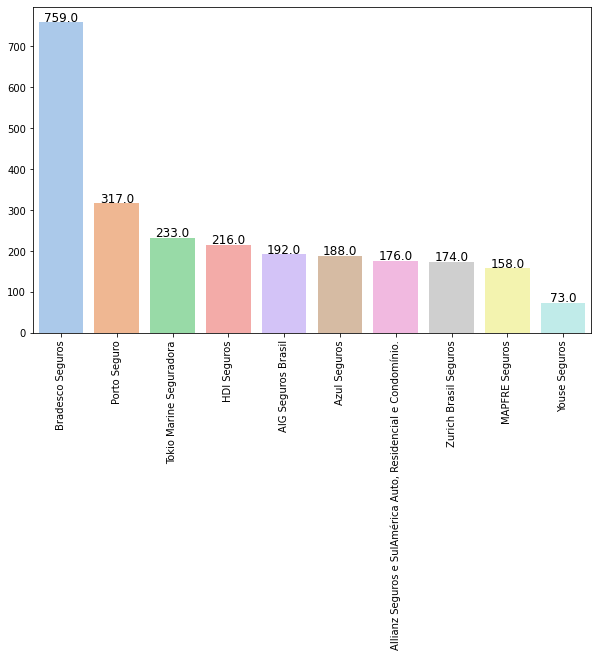

In [31]:
plot = sns.barplot(x='empresa',y='qtd_reclamacoes',orient='v',data=reclamacoes,palette='pastel')
plt.xlabel('') #definindo nome do eixo X
plt.ylabel('') #definindo nome do eixo Y
plt.xticks(rotation=90)
for i in plot.patches:
    plot.annotate(i.get_height(),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha='center',
                  va='baseline',
                  fontsize=12,
                  color='black',
                  xytext=(0, 1),
                  textcoords='offset points')

Pode-se observar na Figura que a maioria das reclamações coletadas encontra-se na Bradesco Seguros e Porto Seguros. Já o menor número de reclamações das coletadas encontra-se na Mapfre Seguros e Youse seguros.

### Distribuição Geográfica das Reclamações por Estado

In [69]:
import geopandas as gpd
import basedosdados as bd
from shapely import wkt

In [32]:
# Criando variável com a query em sql
query = """
SELECT * FROM `basedosdados.br_geobr_mapas.uf`
"""

In [33]:
df2 = bd.read_sql(query, billing_project_id='carbide-legend-331517')

Downloading: 100%|██████████| 27/27 [00:14<00:00,  1.92rows/s]


In [34]:
df2.head()

,id_uf,sigla_uf,geometria
0,11,RO,MULTIPOLYGON (((-63.32720817710296 -7.97672029...
1,12,AC,MULTIPOLYGON (((-73.18252539408962 -7.33549646...
2,13,AM,MULTIPOLYGON (((-67.32608847052386 2.029713905...
3,14,RR,MULTIPOLYGON (((-60.20050657607426 5.264343437...
4,15,PA,MULTIPOLYGON (((-54.95430669626876 2.583692423...


In [74]:
df2['geometria'] = df2['geometria'].apply(wkt.loads)

In [75]:
Info_Ufs =gp.GeoDataFrame(df2, geometry = 'geometria')

In [76]:
Info_Ufs.rename({'sigla_uf':'estado'},axis=1,inplace=True)

In [77]:
Info_Ufs.columns

Index(['id_uf', 'estado', 'geometria'], dtype='object')

In [78]:
reclamacoes = df[['row_hash','estado']]

In [95]:
query = """

    SELECT 
        d.estado,
        COUNT(DISTINCT(row_hash)) AS qtd_reclamacoes
    FROM df AS d
    GROUP BY d.estado
    ORDER BY qtd_reclamacoes DESC
    
    
    """

In [96]:
resultado = sqldf(query)

In [97]:
df4 = resultado.merge(Info_Ufs,on='estado',how='left')

In [98]:
df4

,estado,qtd_reclamacoes,id_uf,geometria
0,SP,1133,35,"MULTIPOLYGON (((-44.90215 -23.35392, -44.90650..."
1,RJ,331,33,"MULTIPOLYGON (((-41.85946 -20.76517, -41.85748..."
2,MG,225,31,"MULTIPOLYGON (((-41.87545 -20.76487, -41.87338..."
3,PR,133,41,"MULTIPOLYGON (((-52.05188 -22.53933, -52.03446..."
4,SC,94,42,"MULTIPOLYGON (((-48.63865 -25.96873, -48.63434..."
5,RS,92,43,"MULTIPOLYGON (((-51.90486 -27.45935, -51.90129..."
6,BA,90,29,"MULTIPOLYGON (((-39.36446 -8.53785, -39.35681 ..."
7,DF,73,53,"MULTIPOLYGON (((-47.57461 -15.51341, -47.56997..."
8,PE,66,26,"MULTIPOLYGON (((-32.39705 -3.83294, -32.39774 ..."
9,GO,49,52,"MULTIPOLYGON (((-50.16015 -12.42007, -50.15856..."


In [101]:
df5 = df4[['geometria','qtd_reclamacoes']]

In [102]:
df5.dropna(inplace=True)

In [103]:
df5['geometria'] = df5['geometria'].apply(wkt.loads)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/alex/.virtualenvs/ra/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_34079/3907261701.py", line 1, in <cell line: 1>
    df5['geometria'] = df5['geometria'].apply(wkt.loads)
  File "/home/alex/.virtualenvs/ra/lib/python3.10/site-packages/pandas/core/series.py", line 4433, in apply
  File "/home/alex/.virtualenvs/ra/lib/python3.10/site-packages/pandas/core/apply.py", line 1082, in apply
  File "/home/alex/.virtualenvs/ra/lib/python3.10/site-packages/pandas/core/apply.py", line 1137, in apply_standard
  File "pandas/_libs/lib.pyx", line 2870, in pandas._libs.lib.map_infer
  File "/home/alex/.virtualenvs/ra/lib/python3.10/site-packages/shapely/wkt.py", line 22, in loads
    return geos.WKTReader(geos.lgeos).read(data)
  File "/home/alex/.virtualenvs/ra/lib/python3.10/site-packages/shapely/geos.py", line 327, in read
    raise 

In [104]:
df6 = gp.GeoDataFrame(df5, geometry = 'geometria')

In [105]:
type(df6)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

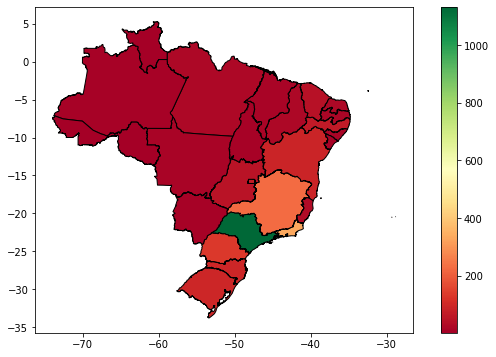

In [106]:
df6.plot(column='qtd_reclamacoes', cmap='RdYlGn', edgecolor='k', legend=True)

Com base na figura, observa - se que a região Sudeste do Brasil, apresent-se uma maior média de nota para os estados das regiões, indicando que nesses estados se tem  sentimento posítivo quanto a resolução das reclamações dos clientes. Já a região Nordeste, apresenta-se em uma certa parte com sentimento negativo maior quanto as reclamações do que as outras regiões.

## Análise descritiva das Notas x Tempo

In [160]:
df[['empresa','nota','dias_passados']].groupby('empresa').describe()

nota                                            \
                         count      mean       std  min   25%  50%   75%   
empresa                                                                    
AIG Seguros Brasil       203.0  4.241379  4.144167  0.0  0.00  4.0   9.0   
Allianz Seguros          177.0  4.237288  3.924018  0.0  0.00  3.0   8.0   
Azul Seguros             192.0  5.395833  4.087983  0.0  0.75  7.0  10.0   
Bradesco Seguros         803.0  5.752179  3.919337  0.0  1.00  7.0  10.0   
HDI Seguros              219.0  4.748858  3.868947  0.0  0.00  5.0   8.0   
MAPFRE Seguros           163.0  4.760736  3.824603  0.0  0.00  5.0   8.0   
Porto Seguro             322.0  5.683230  3.915657  0.0  1.00  7.0  10.0   
Tokio Marine Seguradora  235.0  4.000000  3.806203  0.0  0.00  3.0   8.0   
Youse Seguros             76.0  5.315789  3.980655  0.0  1.00  6.0  10.0   
Zurich Brasil Seguros    178.0  4.865169  4.070539  0.0  0.00  5.0   9.0   

                              dias_passados                                   \
                          max         count       mean        std  min   25%   
empresa                                                                        
AIG Seguros Brasil       10.0         203.0  24.699507  15.963242  0.0  11.0   
Allianz Seguros          10.0         177.0  26.644068  18.458888  3.0  12.0   
Azul Seguros             10.0         192.0  18.526042  16.596516  0.0   5.0   
Bradesco Seguros         10.0         803.0  17.851806  17.232435  0.0   6.0   
HDI Seguros              10.0         219.0  18.680365  16.216656  1.0   7.5   
MAPFRE Seguros           10.0         163.0  20.141104  16.823293  1.0   8.0   
Porto Seguro             10.0         322.0  17.698758  16.156727  1.0   7.0   
Tokio Marine Seguradora  10.0         235.0  19.370213  15.064646  0.0   9.0   
Youse Seguros            10.0          76.0  12.907895  12.636643  0.0   4.0   
Zurich Brasil Seguros    10.0         178.0  18.438202  16.225776  1.0   7.0   

                                            
                          50%    75%   max  
empresa                                     
AIG Seguros Brasil       25.0  34.00  69.0  
Allianz Seguros          21.0  38.00  88.0  
Azul Seguros             13.0  30.00  88.0  
Bradesco Seguros         10.0  28.00  94.0  
HDI Seguros              13.0  25.00  87.0  
MAPFRE Seguros           13.0  34.00  92.0  
Porto Seguro             11.0  24.00  83.0  
Tokio Marine Seguradora  14.0  26.00  86.0  
Youse Seguros             7.0  19.00  53.0  
Zurich Brasil Seguros    12.0  25.75  88.0

## Análise das Notas das Seguradoras

### Distribuição Geográfica das Reclamações por Estado

In [9]:
Info_Ufs = gpd.read_file('dados/bc250_2021_11_18.gpkg',layer = 'lml_unidade_federacao_a')

In [10]:
Info_Ufs.rename({'sigla':'estado'},axis=1,inplace=True)

In [11]:
Info_Ufs.columns

Index(['nome', 'geometriaaproximada', 'estado', 'geocodigo', 'geometry'], dtype='object')

In [12]:
notas = df[['nota','estado']]

In [13]:
query = """

    SELECT 
        n.estado,
        AVG(n.nota) AS nota_media
    FROM notas n
    GROUP BY n.estado
    
    """

In [14]:
resultado = sqldf(query)

In [15]:
df4 = resultado.merge(Info_Ufs,on='estado',how='left')

In [16]:
df5 = df4[['geometry','nota_media']]

In [17]:
df5.dropna(inplace=True)

/tmp/ipykernel_5101/4279374786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.dropna(inplace=True)


In [18]:
type(df5)

pandas.core.frame.DataFrame

In [21]:
df6 = gp.GeoDataFrame(df5)

Text(0.5, 1.0, 'Nota média das Reclamações das Seguradoras por Estado')

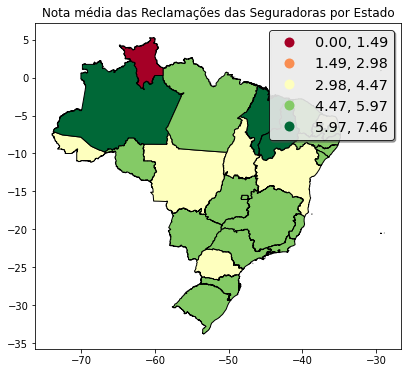

In [32]:
df6.plot(column='nota_media', cmap='RdYlGn',scheme='equal_interval', edgecolor='k', legend=True)
plt.title('Nota média das Reclamações das Seguradoras por Estado')

Com base na figura, observa - se que a região Sudeste do Brasil, apresent-se uma maior média de nota para os estados das regiões, indicando que nesses estados se tem  sentimento posítivo quanto a resolução das reclamações dos clientes. Já a região Nordeste, apresenta-se em uma certa parte com sentimento negativo maior quanto as reclamações do que as outras regiões.

### Análise de Nota por Seguradora

Text(0, 0.5, '')

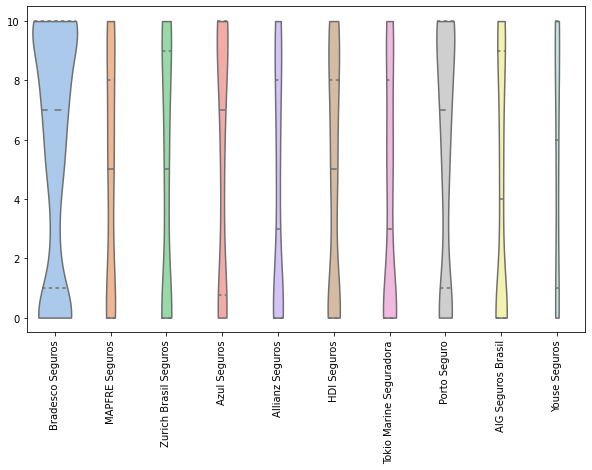

In [14]:
sns.violinplot(x=df["empresa"], y=df["nota"], split=True,cut = 0,scale = 'count',inner='quartile',palette="pastel")
plt.xticks(rotation=90)
plt.xlabel('') #definindo nome do eixo X
plt.ylabel('') #definindo nome do eixo Y

In [1]:
Podemos analisar por meio da figura que o violi plot das notas por empresa. Desta forma, observa-se que as notas estão mais distribuidas entre 3 a 4 e 5 a 7

SyntaxError: invalid syntax (<ipython-input-1-bf722167cf2d>, line 1)

### Análise das Notas por Empresa e Status

Text(0, 0.5, '')

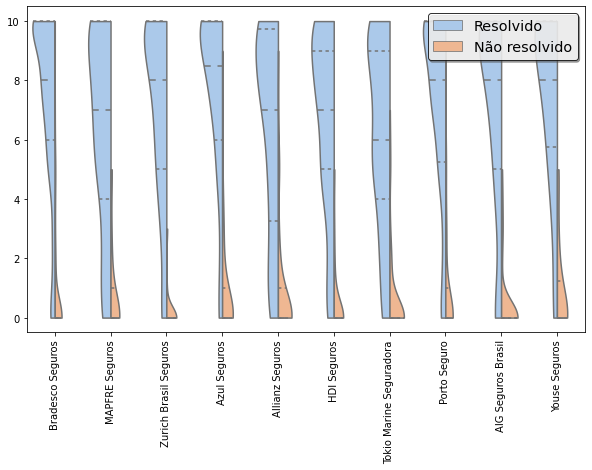

In [152]:
sns.violinplot(data=df, x="empresa", y="nota",hue="status",split=True,cut = 0,scale = 'count',inner='quartile',palette="pastel")
plt.xticks(rotation=90)
plt.legend(loc = 1)
plt.xlabel('') #definindo nome do eixo X
plt.ylabel('') #definindo nome do eixo Y

Text(0, 0.5, '')

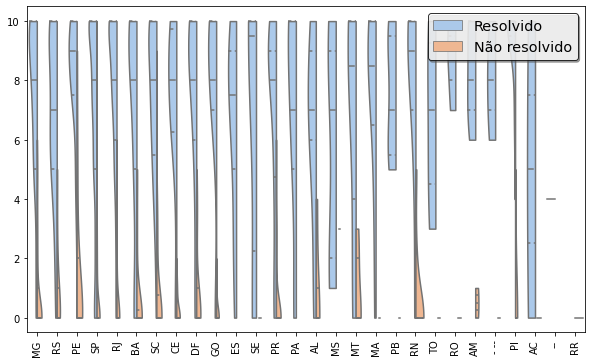

In [153]:
sns.violinplot(data=df, x="estado", y="nota",hue="status",split=True,cut = 0,scale = 'count',inner='quartile',palette="pastel")
plt.xticks(rotation=90)
plt.legend(loc = 1)
plt.xlabel('') #definindo nome do eixo X
plt.ylabel('') #definindo nome do eixo Y

## Análise do Tempo de Resposta das Seguradoras

In [15]:
df['TempoAjustado'] = (df['dias_passados'].max() - df['dias_passados'])/(df['dias_passados'].max() - df['dias_passados'].min())

### Análise do Tempo de Resposta por Seguradora

Text(0, 0.5, '')

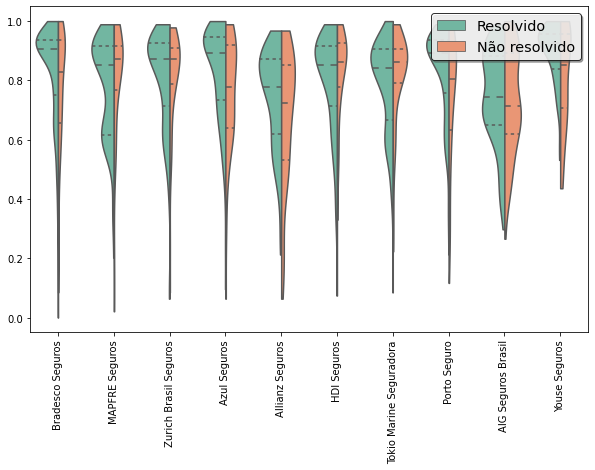

In [23]:
sns.violinplot(data=df, x="empresa", y="TempoAjustado", hue="status",cut = 0 ,split=True,scale = 'count',inner='quartile',palette="Set2")
plt.xticks(rotation=90)
plt.legend(loc = 1)
plt.xlabel('') #definindo nome do eixo X
plt.ylabel('') #definindo nome do eixo Y

### Análise do Tempo de Resposta por Segurados e Status

Text(0, 0.5, '')

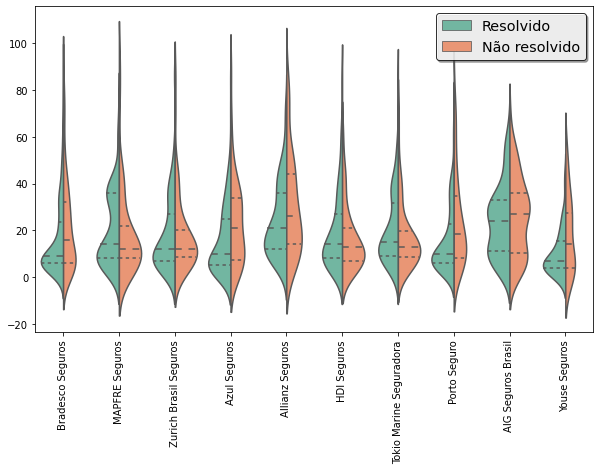

In [34]:
sns.violinplot(data=df, x="empresa", y="dias_passados",hue="status", split=True, inner='quartile',palette="Set2")
plt.xticks(rotation=90)
plt.legend(loc = 1)
plt.xlabel('') #definindo nome do eixo X
plt.ylabel('') #definindo nome do eixo Y